### Time Analysis of the Website's Attractiveness to the Different Classes of Raters

In [279]:
import pandas as pd
import numpy as np

import ingestion as ing

import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the data

In [280]:
# read the users
users_ddf = ing.read_parquet(
    path=ing.build_path(folderind="ba", filename="users_with_scores", ext=".parquet", basepath=ing.REFINED_PATH),
    keepcols=None,
    assume_missing=False,
    mode="lazy")

In [281]:
# compute dataframe
users_df = users_ddf.compute()
users_df.columns

Index(['n_ratings', 'n_reviews', 'uid', 'username', 'joined', 'location',
       'country', 'cfm_score', 'exp_score', 'xpl_score', 'adv_score', 'is_cfm',
       'is_exp', 'is_xpl', 'is_adv'],
      dtype='object')

In [282]:
# added a "classified" column to the dataframe to easily find classified/unclassified users
class_indicators = ["is_cfm", "is_exp", "is_xpl", "is_adv"]
users_df = users_df.assign(classified=(users_df[class_indicators].sum(axis=1) != 0).astype(int))
users_df.columns

Index(['n_ratings', 'n_reviews', 'uid', 'username', 'joined', 'location',
       'country', 'cfm_score', 'exp_score', 'xpl_score', 'adv_score', 'is_cfm',
       'is_exp', 'is_xpl', 'is_adv', 'classified'],
      dtype='object')

In [283]:
# sanity check, should be TRUE
len(users_df.query("classified == 0")) + len(users_df.query("+".join(class_indicators) + " > 0")) == len(users_ddf)

True

### Time Analysis

Users joining the website grouped by year

In [284]:
# all users accounted for
by_year = users_df.groupby(by=users_df.joined.dt.year, as_index=False)

In [285]:
# conformists
cfms = users_df.query("is_cfm == 1")
cfms_by_year = cfms.groupby(by=cfms.joined.dt.year, as_index=False)

In [286]:
# expert-like users
exps = users_df.query("is_exp == 1")
exps_by_year = exps.groupby(by=exps.joined.dt.year, as_index=False)

In [287]:
# adventurers
advs = users_df.query("is_adv == 1")
advs_by_year = advs.groupby(by=advs.joined.dt.year, as_index=False)

In [288]:
# explorers
xpls = users_df.query("is_xpl == 1")
xpls_by_year = xpls.groupby(by=xpls.joined.dt.year, as_index=False)

In [289]:
by_year_user_classes = {
    "cfms": cfms_by_year,
    "xpls": xpls_by_year,
    "exps": exps_by_year,
    "advs": advs_by_year
    }

Evolution of Signed-Ups over Time

In [292]:
len(users_ddf) - len(xpls)

0

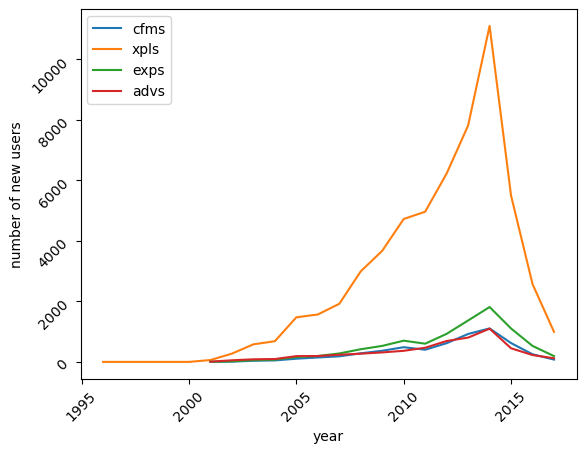

In [290]:
# the distribution of users joining over time
_, ax = plt.subplots(1, 1)
for df in by_year_user_classes.values():
    sns.lineplot(data=df.size(), x="joined", y="size", ax=ax)
ax.set_xlabel("year")
ax.set_ylabel("number of new users")
ax.tick_params(labelrotation=45)
ax.legend(labels=by_year_user_classes.keys())

AttributeError: 'DataFrameGroupBy' object has no attribute 'dt'

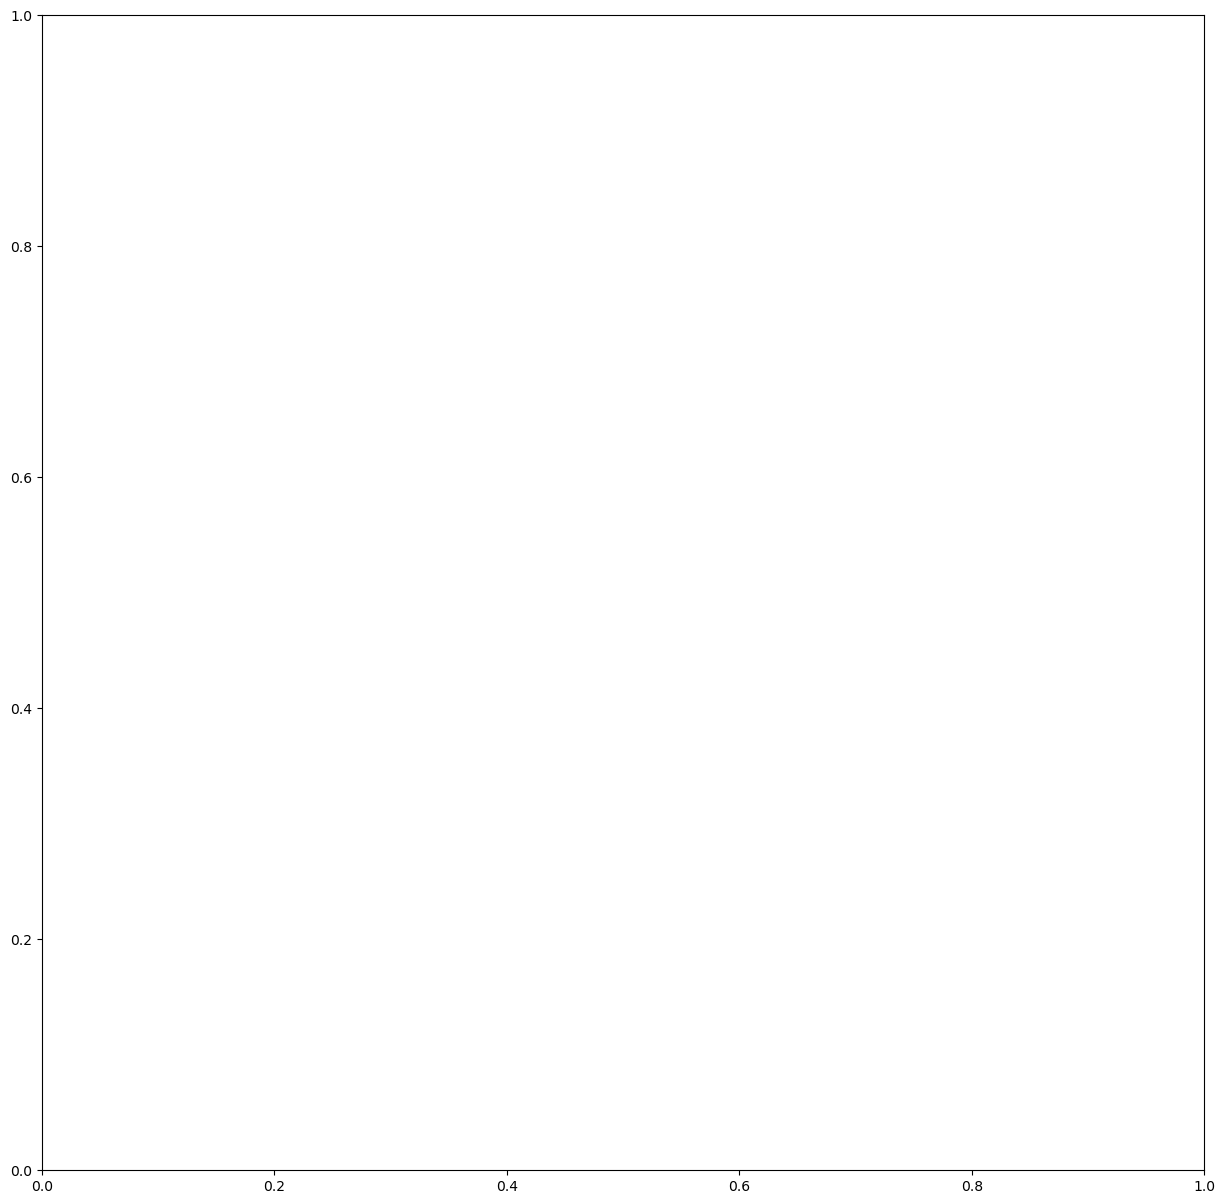

In [72]:
# plot the yearly contribution of each class to the audience
_, ax = plt.subplots(1, 1, figsize=(15, 15))
for year, data in by_joining_year:
    sns.barplot(data=data, x=by_joining_year.joined.dt.year, ax=ax)

In [ ]:
# stack plot